<a href="https://colab.research.google.com/github/viriditass/Papers/blob/main/Designing_Network_Design_Spaces.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Designing Network Design Spaces**

논문 링크: https://arxiv.org/abs/2003.13678

본 논문의 RegNet은 2020년 3월에 나온 논문으로 당시 최고의 성능을 보여주는 EfficientNet보다 빠르고 성능이 좋은 모델이다.

본 논문은 EfficientNet처럼 하나의 best model을 만드는 것이 중점이 아닌 뛰어난 model을 어떤 세팅에서도 사용할 수 있도록 design space를 디자인 하는 것이 논문의 중심이 된다.

Architecture를 만드는 방법은 크게 두 가지가 있는데, 전자는 직접 모델을 만드는 manual한 방식이며 후자는 특정한 search space안에서 좋은 모델을 자동으로 찾아주는 **NAS(Neural Achitecture Search)** 방식이 있다. 자동으로 찾아주는 장점으로 인해 NAS이 많이 사용이 되지만, **특정 세팅에만 적합한 single network instance를 만들기 때문에 general하지 않다**는 한계점이 존재한다.

따라서 본 논문에서는 네트워크 구조 설명이 가능하며 모든 세팅을 아울러 잘 작동하는 manual design 방식의 장점과 semi-automated procedure이 가능한 NAS 방식의 장점을 조합한 새로운 design 패러다임을 제안한다. 즉, 전체적으로 하나의 특정 network instance가 아닌 network의 population들을 parameter화 시킨 **design space**를 디자인하는 것이 목적이다. (**기존 search space는 단 하나의 instance를 뽑아내는 것이 목적이 었다면 design space는 instance들을 뽑아내기 위한 space를 직접 뽑아내는 것이 목적이다.**)

## **Tools for Design Space Design**(design sapce 평가)

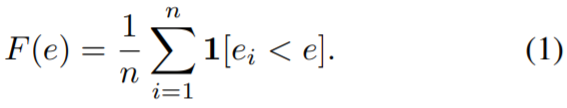

본 논문은 design space을 평가하기 위해 위의 식(**EDF: empirical distribution function**)과 같은 방법을 사용했는데, 해당 design space에서 모델 세트를 sampling하고 모델 오류 분포 결과를 특성화하여 design sapce의 quality을 정량화한다. 이것은 분포를 비교하는 것이 더 강인하며 search algorithms을 사용하는 것보다 더 유익하다.

모델의 분산을 얻는 방법은 design space에서 n개의 model을 sampling하고 training한다. (이때, 효율성을 위해 400M FLOPs와 10 epochs만을 사용)

**n이 100일 때, ImageNet dataset에 대해 model들 모두를 학습하는 것과 ResNet-50을 학습하는 것과 같은 FLOPs를 가진다.**

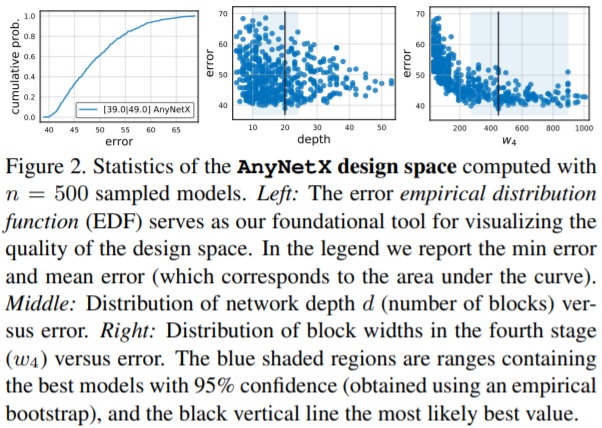

위의 그림 Figure 2의 중간과 우측에 있는 부분은 다양한 network의 property들을 나타낼 수 있다는 것을 보여주며, empirical bootstrap을 사용시 측정할 수 있다.

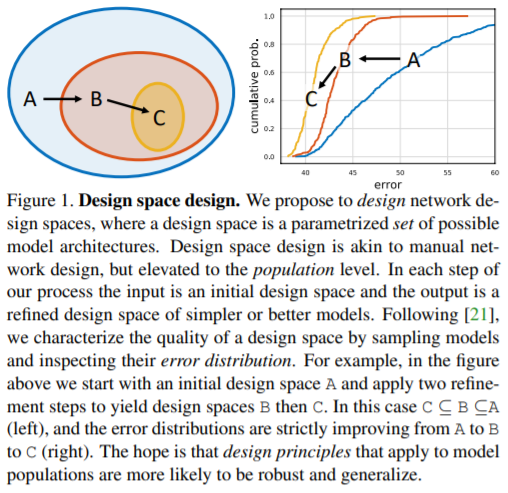

요약하자면, 
1. design space로부터 n개의 model들을 sampling하고 training하여 model의 분포를 얻는다.
2. EDF를 사용해 design space의 quality를 계산하고 시각화한다. 
3. design sapce의 속성을 보고 empirical bootstrap을 통해 insight를 얻는다.
4. 3을 통해 design space를 다시 재정의하여 더 나은 design space를 만든다.

논문의 첫 페이지에 있는 위의 그림 Figure 1가 바로 이 과정 즉, **AnyNetX에서부터 조금씩 constraint를 붙여가며 RegNet까지 도달하는 과정**을 나타낸 것이다. (AnyNetX와 RegNet에 대해서는 아래에서 살펴보겠다.)

## **RegNet 구조**

먼저 표준이되는 고정된 network를 결정해야한다.

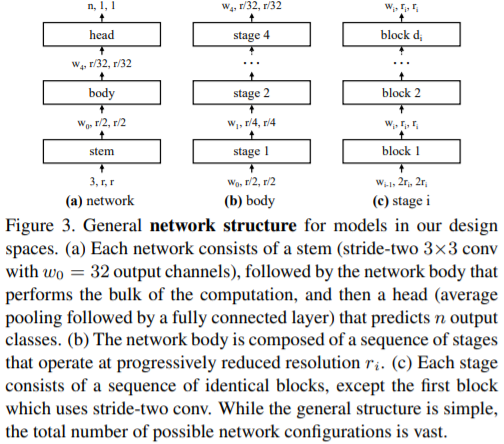

Network의 기본 뼈대가 되는 **AnyNet**는 위의 그림 Figure 3과 같이 stem, body, head 순으로 이루어져 있으며 network의 계산량과 성능에 큰 영향을 끼치는 (b) 부분 즉, body 부분에 집중하게 수정을 진행한다.(**여기서 stem과 head를 최대한 고정시키고 네트워크의 body를 변경**) 또한, 이 body 부분은 (c) 부분과 같은 stage가 총 4개가 연결되어 있으며, 이 stage들 또한 여러개의 block으로 이루어져 있다.

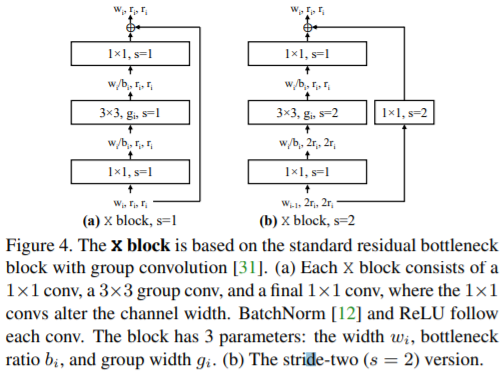

위의 그림 Figure 4에서 볼 수 있듯이 residual bottleneck block을 사용한 network를 **AnyNetX**라고 하며, AnyNetX는 16 degrees of freedom을 가지는데, 4개의 stage와 각 stage들은 다시 4개의 parameter를 가지기 때문이다. 여기서 4개의 parameter는 block의 갯수 d_i, block width w_i, bottleneck ratio b_i, grop width g_i를 의미한다. (d_i는 16 이하, w_i는 1024의 약수 중 8의 배수, b_i는 {1, 2, 4} 중 1개, g_i는 {1, 2, 4, 8, 16, 32} 중 1개이다.

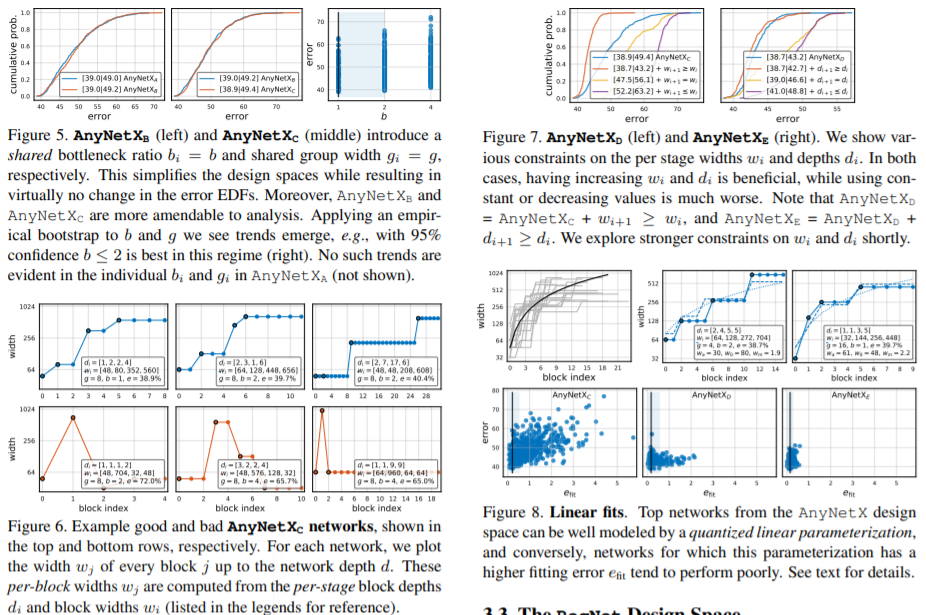

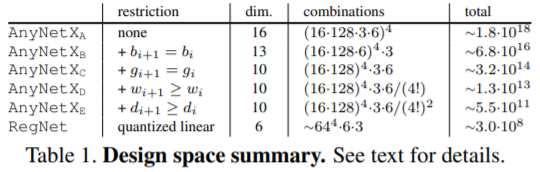

AnyNetX를 4가지의 접근법을 적용하여 총 5가지로 나누었다. (위의 표 Table 1 참고)

**AnyNetX_A는 아무런 제약조건이 없는 AnyNetX**를 의미한다. 조합할 수 있는 경우의 수가 굉장히 많기 때문에 자유도가 그만큼 높다.

**AnyNetX_B의 경우 AnyNetX_A에서 bottleneck ratio를 제한**한다. 즉, 모든 stage에 대해 bottleneck ratio b_i를 b로 고정시킨다. 위의 그림 Figure 5의 좌측 부분이 AnyNetX_A와 AnyNet_B에 대해 각각 500개의 model을 만들어 비교한 것인데, 큰 차이가 없다. 또한, 우측은 b에 따른 결과를 보여준다.

**AnyNetX_C의 경우 AnyNetX_B에서 group width g_i를 g로 제한**했다. 위의 그림 Figure 5의 중앙 부분이 결과를 비교한 것인데, 성능 변화에 큰 차이점이 없는 것을 알 수 있다.

**AnyNetX_D는 AnyNetX_C에서 좋은 network와 안좋은 network에 대해 탐구한 것**이며, 위의 그림 Figure 6을 통해 widths가 증가할 수록 성능이 증가하는 패턴을 발견하였다. 따라서 w_(i+1) >= w_i라는 원칙을 발견하였다.  위의 그림 Figure 7를 보면 바로 알 수 있다.

**AnyNexX_E는 stage depths d_i와 stage widths w_i를 같이 형성하였다.** (d_(i+1) > d_i)위의 그림 Figure 7에서 볼 수 있으며, w_i와 d_i는 각각 4!만큼 줄었다.

위의 그림 Figure 8에서 좌측 상단은 최고의 성능을 보이는 20개의 model들을 보여준다. 또한, grady curves는 각 모델의 편차를 보여주는데, 이때 **w_j = 48·(j+1) for 0 ≤ j ≤ 20**의 패턴이 나타난다. 놀랍게도 이 사소한 linear fit은 상위 model에 대한 network width 증가의 모집단 추세를 설명한다. 하지만, linear fit은 각 블록마다 다른 width를 할당하는 것처럼 보일 수 있다.

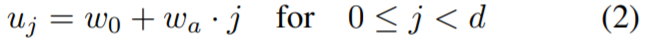

본 논문의 저자는 이러한 패턴을 개별적인 model에 적용하기 위해 picewise constant function을 양자화하는 전략을 선택하였다. 즉, 각 block의 width들을 위의 식과 같은 **linear parameterization**으로 할당하는 것이다. 위의 식은 3가지 parameter인 depth d, initial width w_0 > 0, slope w_a > 0을 필요로 한다.

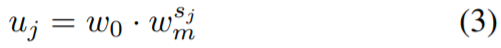

이제 다시 **u_j를 quantize하기** 위하여 추가적인 parameter w_m > 0을 도입한다. 이는 width multiplier로 이전 stage의 width를 몇 배나 할지 결정해주는 parameter이다.

위의 식으로 각 block j에 대한 s_j를 계산하면 된다.

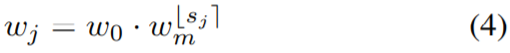

그리고 u_j를 quantize하는데 앞서 구한 s_j에 round를 취한 뒤 quantize된 per-block width인 w_j를 구할 수 있다.

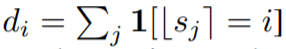

이제 constant widht를 가진 block의 수를 세어 per-block w_j를 per-stage 폼으로 나타낼 수 있게 되었으므로 각각의 stage i에서 block width는 w_i = w_0 · w_m^i로 나타낼 수 있다. 이때, block의 수는 위의 식과 같이 나태날 수 있다.

조금 복잡하긴 하지만, 간단히 요약하면 model을 생성하는 design space를 공식을 통해 쉽게 구하는 것이라고 생각하면 된다.

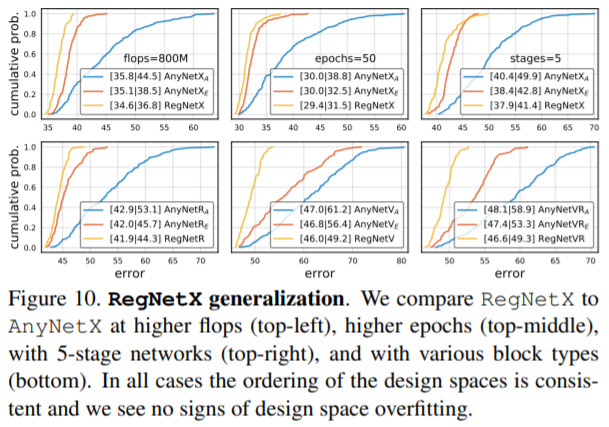

결론적으로 **network의 구조는 6개의 parameter인 d, w_0, w_a, w_m, b, g로 결정**이 되며, 이러한 design space를 regular network, **RegNet**이라고 한다. 이때 RegNet와 RegNetX는 같으며, RegNexX에 SE(Squeeze-and-Excitation) 연산을 추가한 것을 **RegNetY**라고 부른다. 위의 그림 Figure 10을 보면 RegNet의 성능을 알 수 있다.

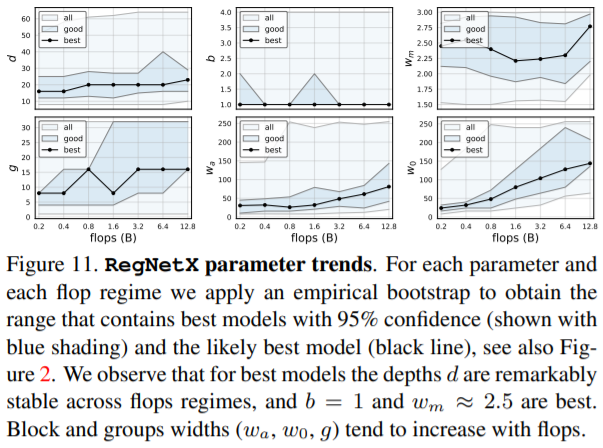

위의 그림 Figure 11을 보면 RegNetX의 trend를 볼 수 있다. best model의 depth는 모든 regime에 대해서도 안정적으로 비슷한 값을 가지며, 최적의 depths는 ~20 block이다. 이는 더 높은 flop을 위해 더 depp한 model을 사용하는 현실과는 대조적인 결과이다. best model에 대한 bottleneck ratio b는 1이며 bottleneck 없이 하는 것이 가장 최적의 성능을 보인다. 또한 width multiplier w_m은 2.5정도로 최근 model들이 이 값을 2 정도로 하는 것과 비슷한 양상을 보인다.

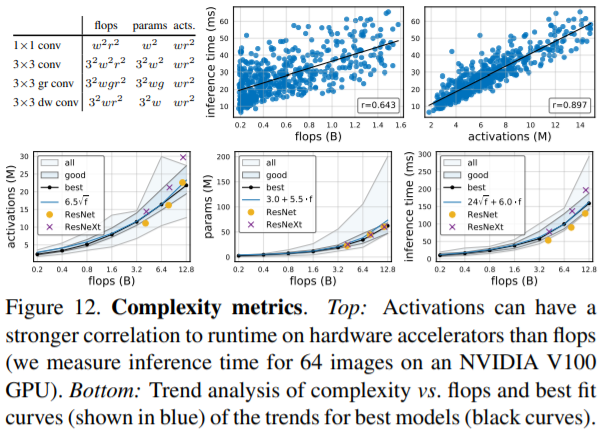

convolution layer의 output의 size를 의미하는 activation은 자주 측정되는 값은 아니지만, runtime에 큰 영향을 미치는 값 중 하나이다. RegNet에서 best model들은 이 activation이 square-root로 flop에 따라 증가하고 있으며, parameter들은 linaer하게 증가하는 것을 위의 그림 Figure 12를 통해 알 수 있다.

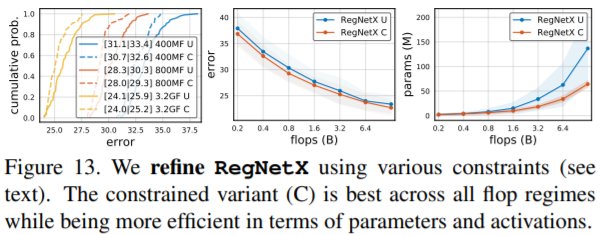

본 논문의 저자들은 RegNetX의 design space를 b = 1, d <= 20, w_m >= 2 그리고 parameter와 activation이 각각 square-root와 linear하게 증가하도록 정의한다.  이렇게 제한을 두어 재정의한 RegNetX design space의 결과는 위의 그림 Figure 13과 같다.

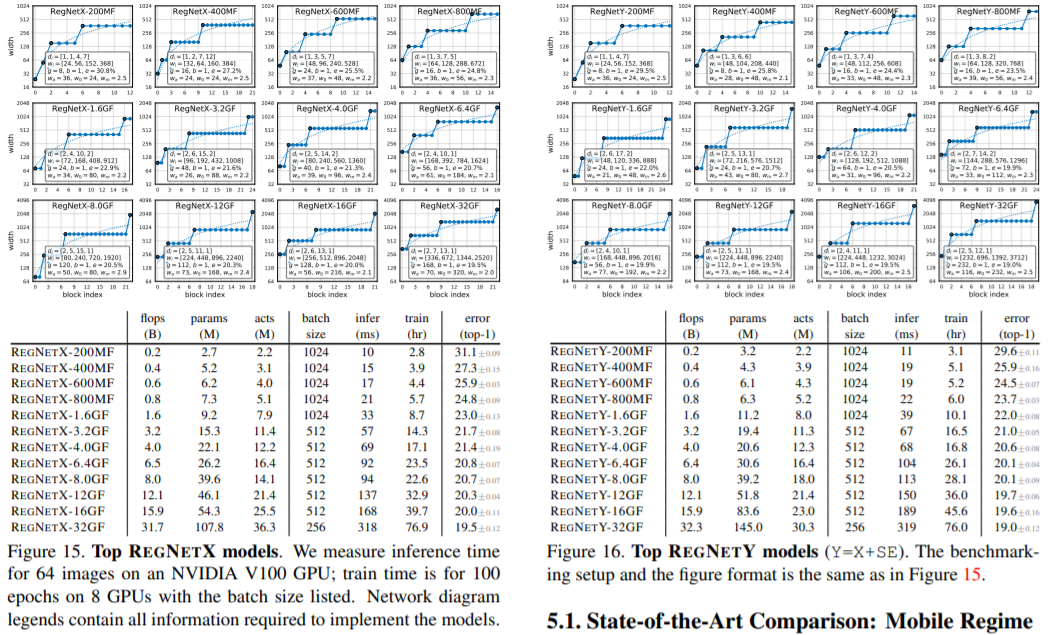

위의 그림들 Figure 15, Figure 16에서 RegNetX와 RegNetY에서 각각 25개의 무작위 세팅에서 뽑은 best model을 선별하고 이 best model을 5번 100 epoch로 돌린 결과를 볼 수 있다.

여기서 중요한 포인트는 **더 높은 flop을 가진 model일 수록 3번째 stage에서 block의 갯수가 제일 많았으며 마지막 stage에서는 굉장히 적은 수의 block을 가지는 것**을 알 수 있다. 또한 group width g는 더 큰 model에 따라 그 값이 증가했으며, depth d는 saturation되는 것을 볼 수 있다.

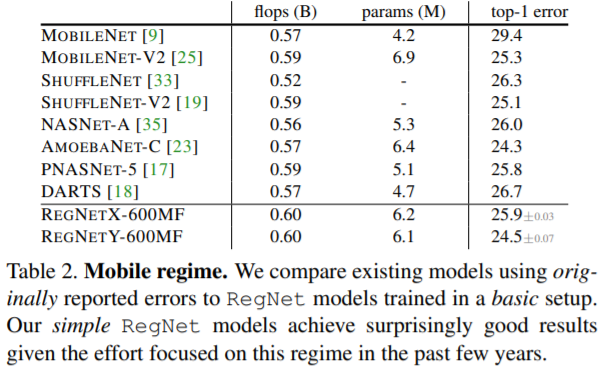

모바일에 들어가야하는 model들은 그 크기가 작으면서 동시에 성능이 좋아야한다. 위의 표 Table 2를 보면 알 수 있듯이 RegNet은 아무것도 추가하지 않은 basic한 모델이므로 더욱 성능이 좋다

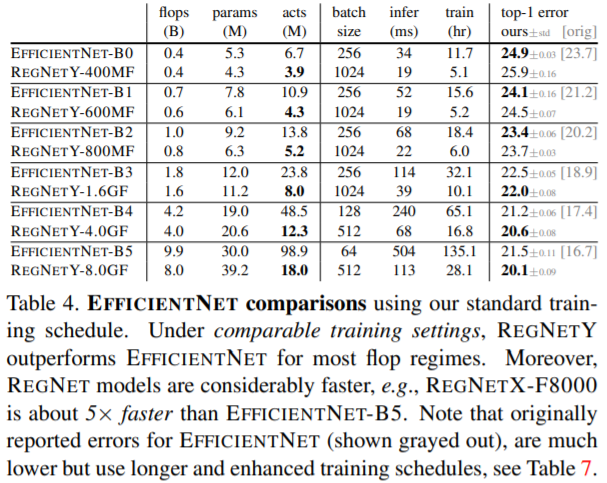

전체적인 비교를 위해 SOTA 성능을 보이는 EfficientNet과 비교를 했다.(Facebook vs Google 느낌인가...) Network 구조 자체의 성능만을 철저히 비교하기 위해 본 논문의 저자들이 EfficientNet 또한 재구현을 했다. 낮은 flop에서는 EfficientNet의 성능이 더 좋았지만, flop이 높아질수록 RegNetY와 RegNetX 모두 EfficientNet보다 좋은 성능을 보여줬다. 또한 EfficientNet의 경우, activation이 flop에 따라 linaer하게 증가하고 RegNet의 경우는 square-root로 증가하기 때문에 속도 차이가 무려 5배나 난다.